#Dependencies

In [7]:
# pip install lime


In [ ]:
!pip install -q optuna


In [1]:
 !pip install -q -U bnlp_toolkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 50.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 40.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 30.7 MB/s eta 0:00:00:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.16.11 requires scipy>=1.11.2, but you have scipy 1.10.1 which is incompatible.
mlxtend 0.23.3 require

In [9]:
# !gdown 1y6R4r2azEusl4bLyussZcZvo3-wI3dCn

In [10]:
# !pip install fasttext

In [2]:
import torch
import torch.nn as nn
import sklearn
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import fasttext
from bnlp import BasicTokenizer
from bnlp import SentencepieceTokenizer
from bnlp import BengaliWord2Vec
from bnlp import NLTKTokenizer
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import precision_recall_fscore_support


In [3]:
df = pd.read_csv("/kaggle/input/ctsl-data/ctsl_data.csv")


In [5]:
df = df.drop(columns=['hate speech','type','lemmatized_sentence'])

#Describe Dataset

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40224 entries, 0 to 40223
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  40224 non-null  object
 1   target    19324 non-null  object
dtypes: object(2)
memory usage: 628.6+ KB


In [7]:
df.isnull().sum()

sentence        0
target      20900
dtype: int64

In [9]:
df.head()

,sentence,target
0,ঐ ইন্দুর তোই মরছ নাই,ind
1,গেবনের শেষে আইসা আপনার মুখোশ টা খুলছে এতেই আমি...,ind
2,মুরগি চোরের পাছায় ডুকবি আর মারবি,ind
3,কোটির চোদা খাওয়া শেষে এখন কোটির চোদা খাবে মিথিলা,female
4,য় মীর জাফরের মুখে মুতে দে,male


In [59]:
target_counts

,target,count
0,ind,7057
1,male,5413
2,female,4093
3,group,2486
4,male_female,225
5,female_group,18
6,male_group,13
7,ind_female,10
8,ind_group,5
9,male_female_group,3


In [8]:
import plotly.express as px

# Plot the distribution of 'target'
target_counts = df['target'].value_counts().reset_index()
target_counts.columns = ['target', 'count']  # Rename the columns for clarity

fig_target = px.bar(target_counts, 
                    x='target', 
                    y='count', 
                    labels={'target': 'Target', 'count': 'Count'},
                    title="Distribution of Target",
                    color='target', 
                    color_continuous_scale='Viridis')

# Use `fig.show()` to explicitly display the plot
fig_target.show()

In [9]:
df['target'].fillna('0', inplace=True) # Replace null values with 0
df.isnull().sum() 


sentence    0
target      0
dtype: int64

In [10]:
type_unique = df['target'].nunique() # Number of unique classes
type_unique

12

In [11]:
distinct_classes = df['target'].unique() # Get all unique classes
distinct_classes


array(['ind', 'female', 'male', 'group', 'male_female', 'ind_female',
       'male_group', 'female_group', 'ind_group', 'male_female_group',
       'ind_male', '0'], dtype=object)

In [12]:
class_mapping = {
    '0': 0,
    'ind': 1,
    'female': 2,
    'male': 3,
    'group': 4,
    'male_female': 5,
    'ind_female': 6,
    'male_group': 7,
    'female_group': 8,
    'ind_group': 9,
    'male_female_group': 10,
    'ind_male': 11,

}

# Apply the mapping to the 'type' column
df['encoded_target'] = df['target'].map(class_mapping)

# Verify the encoding
df.head(10)

,sentence,target,encoded_target
0,"['ইন্দুর', 'তোই', 'মর']",ind,1
1,"['গেবন', 'শাষ', 'আইসা', 'মুখোশ', 'টা', 'খুল', ...",ind,1
2,"['মুরগি', 'চোর', 'পাছায়', 'ডুকবি', 'মারবি']",ind,1
3,"['কোটি', 'চোদা', 'খাওয়া', 'শাষ', 'কোটি', 'চোদা...",female,2
4,"['য়', 'মীর', 'জাফর', 'মুখে', 'মুত', 'দে']",male,3
5,"['অই', 'কখানকি', 'সত্যি', 'জান', 'তরে', 'জুদি'...",female,2
6,"['অই', 'জারছি', 'পর', 'লোক', 'টা', 'পাইলে', 'ক...",ind,1
7,"['অক', 'পিথিবির', 'আলো', 'দেখানোর', 'মার', 'ফে...",ind,1
8,"['অক', 'মার', 'ফেল']",ind,1
9,"['অগরে', 'চুদে', 'মেয়ে', 'গূলো']",group,4


In [13]:
distinct_classes = df['encoded_target'].unique()
distinct_classes

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  0])

In [20]:
print(df['sentence'].iloc[2],"\n")
print(df['sentence'].iloc[4],"\n")

মুরগি চোরের পাছায় ডুকবি আর মারবি 

য় মীর জাফরের মুখে মুতে দে 



Tf-idf

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

df['sentence'] = df['sentence'].apply(lambda x: ' '.join(x))  # Join tokens into a single string

# Apply TfidfVectorizer with unigram and bigram
tfidf_bigram = TfidfVectorizer(ngram_range=(1, 2), use_idf=True, tokenizer=lambda x: x.split())

# Apply TF-IDF to the joined (space-separated) text data
x_tfidf_bigram = tfidf_bigram.fit_transform(df['sentence'])

# If you have labels in 'hate speech' column
X_train, X_test, y_train, y_test = train_test_split(x_tfidf_bigram, df['target'], test_size=0.2, random_state=42)


kfold

In [30]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
import numpy as np

# Apply TfidfVectorizer with unigram and bigram
tfidf_bigram = TfidfVectorizer(ngram_range=(1, 2), use_idf=True, tokenizer=lambda x: x.split())

# Apply TF-IDF to the joined (space-separated) text data
x_tfidf_bigram = tfidf_bigram.fit_transform(df['sentence'])

# Labels
y = df['target']

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


Evaluator

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize
def evaluate_model(model, X_test, y_test):
    # Model type display
    print(70*'-')
    print(f"Evaluating model: {model.__class__.__name__}")
    
    # Predict the results
    y_pred = model.predict(X_test)
    
    # For multiclass, we use label_binarize to get binary relevance for each class
    class_labels = ['0',
    'ind',
    'female',
    'male',
    'group',
    'male_female',
    'ind_female',
    'male_group',
    'female_group',
    'ind_group',
    'male_female_group',
    'ind_male'
    ]

    # Binarize the true and predicted labels for multiclass
    y_test_bin = label_binarize(y_test, classes=class_labels)
    y_pred_bin = label_binarize(y_pred, classes=class_labels)

    # Compute accuracy, precision, recall, and F1-score
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')  # or 'micro' or 'weighted'
    recall = recall_score(y_test, y_pred, average='macro')  # or 'micro' or 'weighted'
    f1 = f1_score(y_test, y_pred, average='macro')  # or 'micro' or 'weighted'

    #print("Class distribution in y_test:", pd.Series(y_test).value_counts())
    #print("Class distribution in y_pred:", pd.Series(y_pred).value_counts())

    # Print evaluation metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision (macro): {precision:.4f}')
    print(f'Recall (macro): {recall:.4f}')
    print(f'F1 Score (macro): {f1:.4f}')
    
    # Generate the confusion matrix for multiclass
    cm = confusion_matrix(y_test, y_pred)

    # Plotting the confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()


    print(70*'-')


kfold

In [26]:
# Define the function for training
def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

# Define the function for evaluation
def evaluate_model_kfold(model, X, y, class_labels):
    # Initialize lists to hold the evaluation metrics
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    auc_scores = []
    
    # Lists to accumulate true labels and predicted labels for confusion matrix
    all_y_test = []
    all_y_pred = []
    
    # Cross-validation loop
    for train_index, test_index in skf.split(X, y):
        # Split the data
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Train the model on this fold
        model = train_model(model, X_train, y_train)
        
        # Predict on test set
        y_pred = model.predict(X_test)
        
        # Binarize the true and predicted labels for multiclass
        y_test_bin = label_binarize(y_test, classes=class_labels)
        y_pred_bin = label_binarize(y_pred, classes=class_labels)
        
        # Compute metrics for this fold
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro')  # or 'micro' or 'weighted'
        recall = recall_score(y_test, y_pred, average='macro')  # or 'micro' or 'weighted'
        f1 = f1_score(y_test, y_pred, average='macro')  # or 'micro' or 'weighted'
        
        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        
        # AUC for each class
        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(len(class_labels)):
            if sum(y_test_bin[:, i]) > 0 and sum(y_pred_bin[:, i]) > 0:
                fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])
            else:
                roc_auc[i] = float('nan')  # If there's no positive sample for the class
                
        auc_scores.append(roc_auc)
        
        # Accumulate true and predicted labels for confusion matrix
        all_y_test.extend(y_test)
        all_y_pred.extend(y_pred)
    
    # Print the average metrics across all folds
    print("Average accuracy:", np.mean(accuracy_scores))
    print("Average precision (macro):", np.mean(precision_scores))
    print("Average recall (macro):", np.mean(recall_scores))
    print("Average F1 score (macro):", np.mean(f1_scores))
    
    # Calculate average AUC per class
    for i in range(len(class_labels)):
        auc_per_class = [roc_auc[i] for roc_auc in auc_scores if not np.isnan(roc_auc[i])]
        if auc_per_class:
            print(f'Average AUC for Class {class_labels[i]}: {np.mean(auc_per_class):.4f}')
    
    # Confusion Matrix after all folds
    cm = confusion_matrix(all_y_test, all_y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix (After Cross-Validation)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()


Train & evaluate

random forest

----------------------------------------------------------------------
Evaluating model: RandomForestClassifier
Accuracy: 0.6797
Precision (macro): 0.3078
Recall (macro): 0.2058
F1 Score (macro): 0.2197


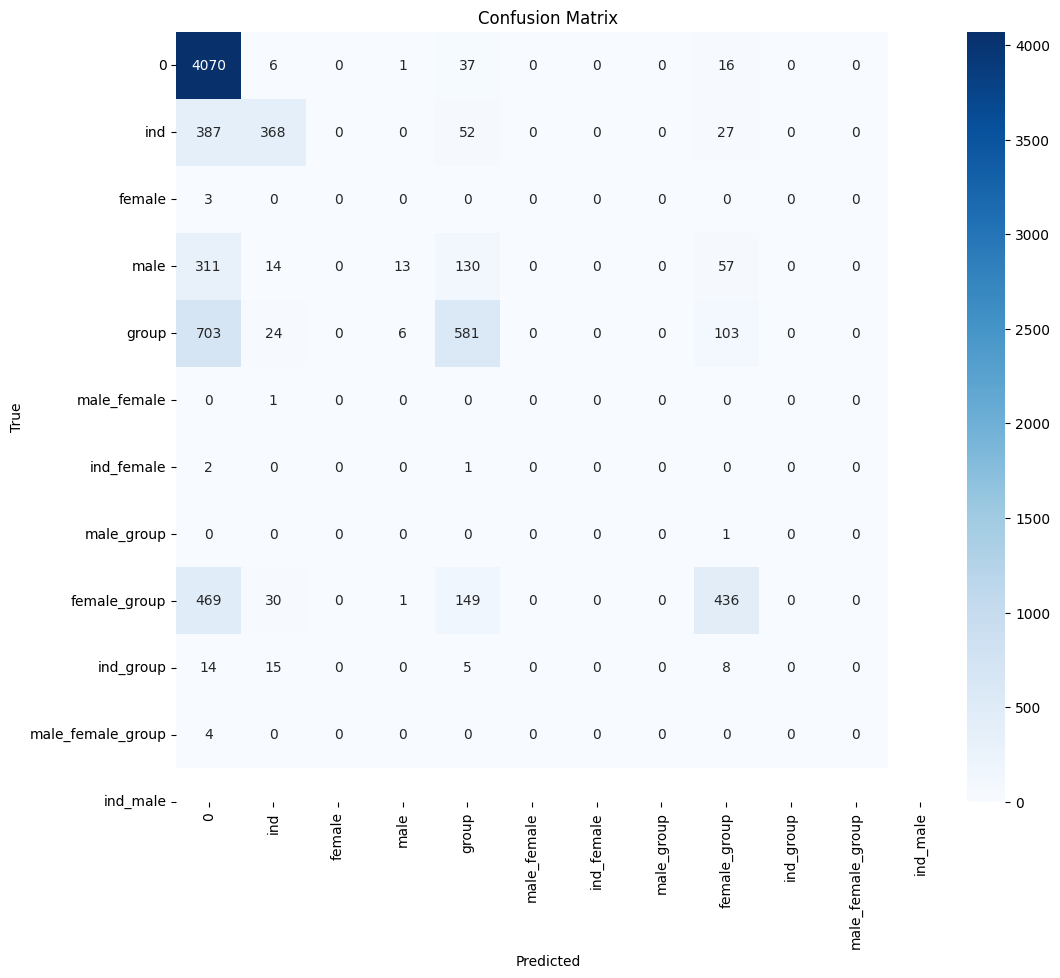

----------------------------------------------------------------------


In [21]:
model_rf = RandomForestClassifier(random_state=42 )
model_rf.fit(X_train, y_train)
evaluate_model(model_rf, X_test, y_test)

kfold rf

Average accuracy: 0.6539875495217571
Average precision (macro): 0.31623016123401476
Average recall (macro): 0.18912829365837033
Average F1 score (macro): 0.20573066930455833
Average AUC for Class 0: 0.6936
Average AUC for Class ind: 0.6362
Average AUC for Class female: 0.6754
Average AUC for Class male: 0.6679
Average AUC for Class group: 0.5128
Average AUC for Class male_female: 0.4999
Average AUC for Class ind_female: 0.4999


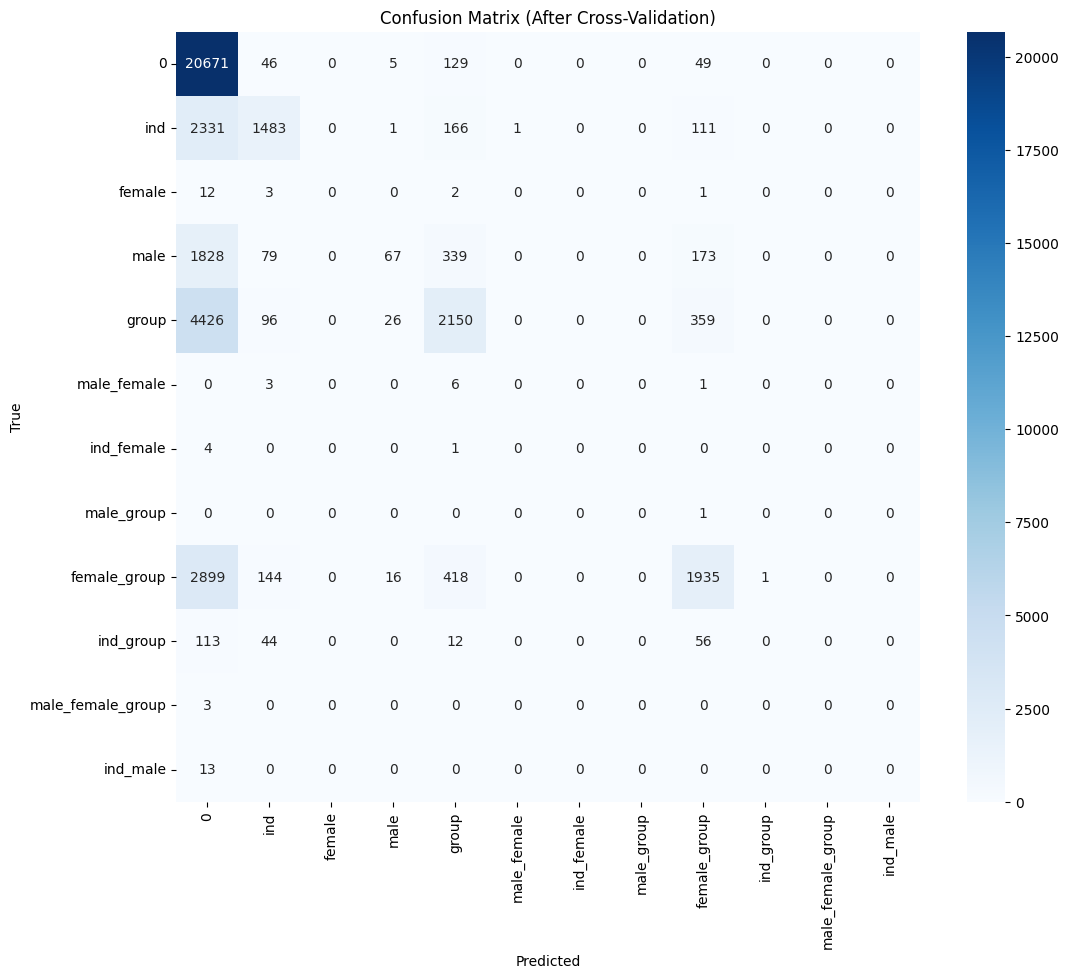

In [31]:
# Initialize your model (e.g., RandomForestClassifier with class weights)
model_rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Define your class labels
class_labels = ['0',
    'ind',
    'female',
    'male',
    'group',
    'male_female',
    'ind_female',
    'male_group',
    'female_group',
    'ind_group',
    'male_female_group',
    'ind_male'
    ]

# Assuming X (features) and y (labels) are already set
evaluate_model_kfold(model_rf, x_tfidf_bigram, df['target'], class_labels)

logistic regression

----------------------------------------------------------------------
Evaluating model: LogisticRegression
Accuracy: 0.7121
Precision (macro): 0.2913
Recall (macro): 0.2444
F1 Score (macro): 0.2570


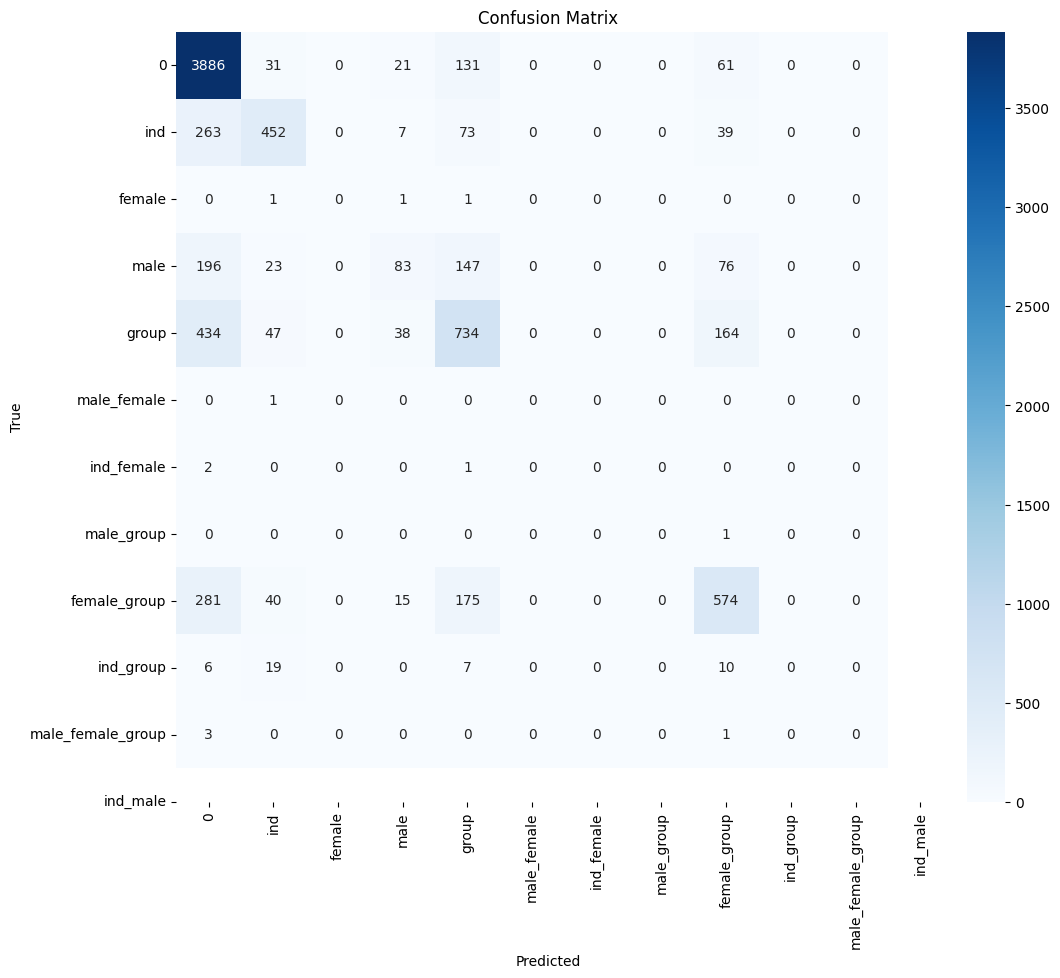

----------------------------------------------------------------------


In [22]:
model_lr = LogisticRegression(penalty='l2',random_state=0)
model_lr.fit(X_train, y_train)
evaluate_model(model_lr, X_test, y_test)

kfold lr

Average accuracy: 0.7212112436910849
Average precision (macro): 0.3009090655126096
Average recall (macro): 0.2522804371960399
Average F1 score (macro): 0.2653954423319204
Average AUC for Class 0: 0.8219
Average AUC for Class ind: 0.7201
Average AUC for Class female: 0.7624
Average AUC for Class male: 0.7531
Average AUC for Class group: 0.5739


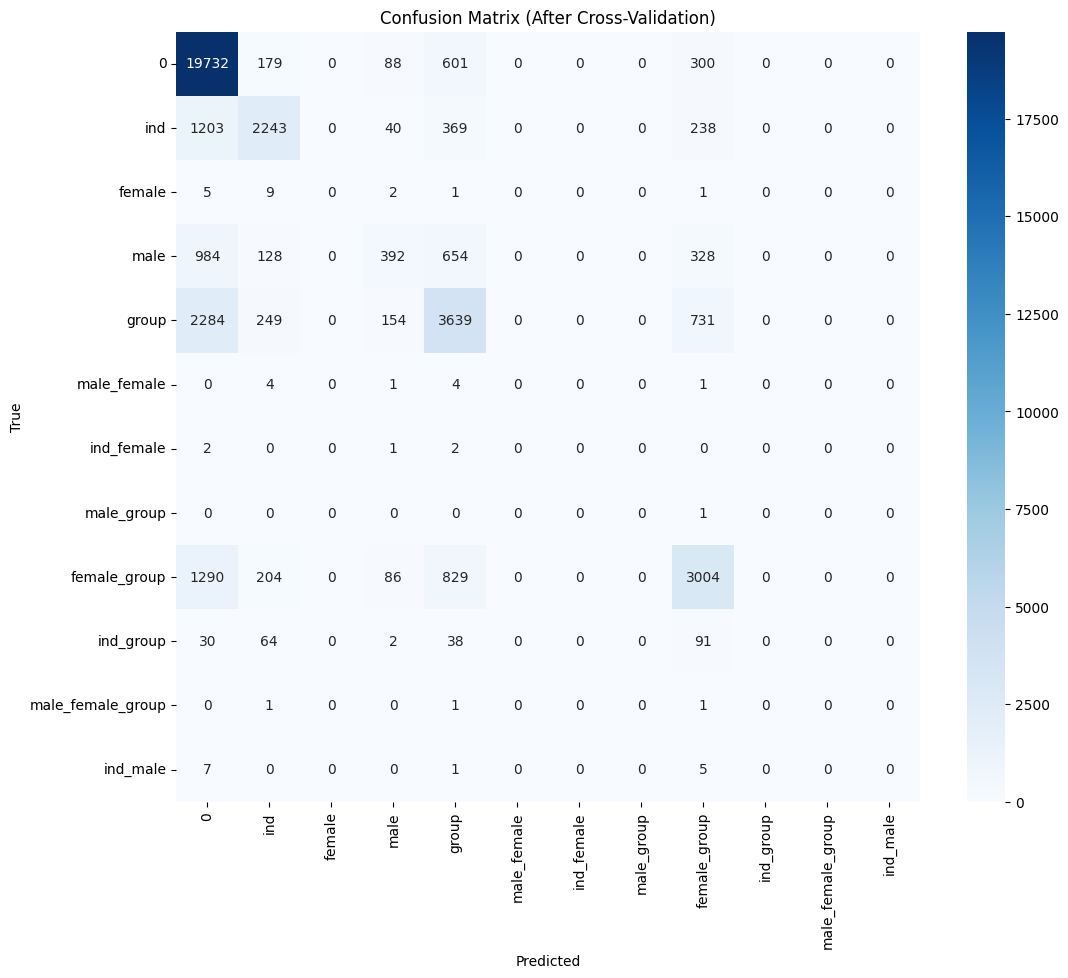

In [32]:
class_labels = ['0',
    'ind',
    'female',
    'male',
    'group',
    'male_female',
    'ind_female',
    'male_group',
    'female_group',
    'ind_group',
    'male_female_group',
    'ind_male'
    ]
model_lr = LogisticRegression(penalty='l2',random_state=0)
evaluate_model_kfold(model_lr, x_tfidf_bigram, df['target'], class_labels)

knn

----------------------------------------------------------------------
Evaluating model: KNeighborsClassifier
Accuracy: 0.6285
Precision (macro): 0.2573
Recall (macro): 0.2257
F1 Score (macro): 0.2363


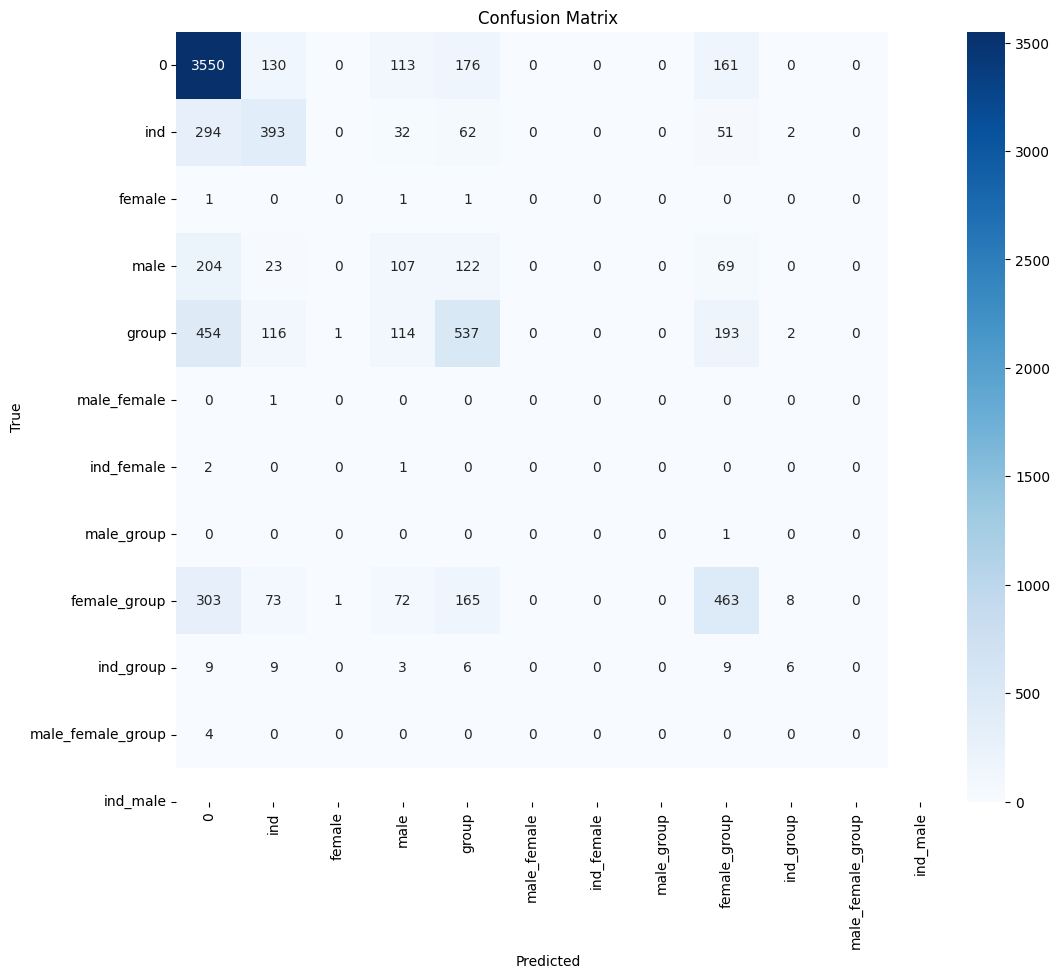

----------------------------------------------------------------------


In [24]:
model_knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
model_knn.fit(X_train, y_train)
evaluate_model(model_knn, X_test, y_test)

kfold knn

In [ ]:
model_knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
# Define your class labels
class_labels = ['0',
    'ind',
    'female',
    'male',
    'group',
    'male_female',
    'ind_female',
    'male_group',
    'female_group',
    'ind_group',
    'male_female_group',
    'ind_male'
    ]

# Assuming X (features) and y (labels) are already set
evaluate_model_kfold(model_knn, x_tfidf_bigram, df['target'], class_labels)